In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!pip install playsound
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
import os
import librosa
from playsound import playsound
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# Model libraries
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Global variables
emotions = {'ANG' : 0, 'DIS' : 1, 'FEA' : 2, 'HAP' : 3, 'NEU' : 4, 'SAD' : 5}
# data used for play_audio functions to get classes of the audio
data = {}
# zero-crossing rate and mel spectrogram feature spaces
x_zcr = []
x_mel = []
# labels of dataset
y = []  

**Reading** **Dataset**

In [ ]:
def scan_folder(parent):
  classes = []
  curr_word = "1001_DFA"
  # iterate over all the files in directory 'parent'
  m = 0
  for file_name in sorted(os.listdir(parent)):
    print(m)
    m+=1
    file_path = parent + '/' + file_name
    #print(file_path)
    word = file_name[0:8]
    if curr_word != word:  
      data[curr_word] = classes
      classes = []
      curr_word = word
    classes.append(file_path)
    # Create zero crossing rate, mel spectrogram feature space and labels array
    x, sr = librosa.load(file_path)
    zcr = librosa.feature.zero_crossing_rate(x)
    mel = librosa.feature.melspectrogram(x)
    x_zcr.append(zcr)
    x_mel.append(mel)
    y.append(emotions[file_path.split('/')[4][9:12]])
scan_folder('drive/MyDrive/PR assignment 3/Crema')

Streaming output truncated to the last 5000 lines.
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631

In [ ]:
def play_audio(audio):
  for x in data[audio]:
    print('Playing audio for file '+x.split('/')[1]+":\n")
    playsound(x)
    # read audio samples
    input_data = wavfile.read(x)
    audio = input_data[1]
    # plot the first 1024 samples
    plt.plot(audio)
    # label the axes
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    # set the title  
    plt.title(x.split('/')[1][0:12])
    # display the plot
    plt.show()
#play_audio("1001_DFA")

In [ ]:
def zero_padding():
  global x_mel
  global x_zcr
  global y

  
   #Zero padding for zcr list
  for i in range(len(x_zcr)):
    zero_padding = np.zeros((1,216))
    zero_padding[:x_zcr[i].shape[0],:x_zcr[i].shape[1]] = x_zcr[i]
    x_zcr[i] = zero_padding
  x_zcr = np.array(x_zcr)
  print("Zero crossing rate shape: ",x_zcr.shape)


  # Zero padding for mel spectrogram list
  for i in range(len(x_mel)):
    zero_padding = np.zeros((128,216))
    zero_padding[:x_mel[i].shape[0],:x_mel[i].shape[1]] = x_mel[i]
    x_mel[i] = zero_padding
  x_mel = np.array(x_mel)
  print("Mel spectrogram shape: ",x_mel.shape)

  # Converting y to numpy array
  y = np.array(y)
  print("Labels shape: ",y.shape)


zero_padding()

Zero crossing rate shape:  (7442, 1, 216)
Mel spectrogram shape:  (7442, 128, 216)
Labels shape:  (7442,)


In [ ]:
#Data Augmentation
def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape)
    return data

**Models**

Before augmentation training x and y size:  (4948, 216, 1) (4948,)
After augmentation training x and y size:  (9896, 216, 1) (9896,)
(9896, 216, 1) (2233, 216, 1) (261, 216, 1) (261,)

Model Inspection

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 214, 32)           128       
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 212, 32)           3104      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 106, 32)           0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 106, 32)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 104, 64)           6208      
_________________________________________________

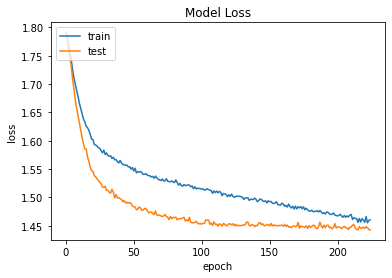

70/70 [==============================] - 0s 4ms/step - loss: 1.4765 - accuracy: 0.4004

Test loss =  1.4764827489852905
Accuracy of the model =  0.40035825967788696
F-score of the model =  0.3720704443856704
Confusion Matrix: 
[[260  29   5  46  13   6]
 [ 94 132  22  42  36  60]
 [ 57  61  29  58  43 123]
 [105  38  13 121  55  46]
 [ 24  46  12  56 118  97]
 [ 10  46  28  23  45 234]]


In [ ]:
def train_model_zcr():
  #Splitting data 70% training , 30% testing
  x_zcr_train, x_zcr_test, y_zcr_train, y_zcr_test = train_test_split(x_zcr, y, test_size=0.3, random_state=42)
  # Reshaping training data
  x_zcr_train = x_zcr_train.reshape(-1, 216, 1)
  x_zcr_test = x_zcr_test.reshape(-1, 216, 1)
  # Normalizing data
  #x_zcr_train = x_zcr_train.astype('float32')
  #x_zcr_test = x_zcr_test.astype('float32')
  #x_mel_train = librosa.util.normalize(x_mel_train)
  #x_mel_test = librosa.util.normalize(x_mel_test)
  #x_zcr_train = x_zcr_train / 255.
  #x_zcr_test = x_zcr_test / 255.
  
  #print(x_mel_train.shape, x_mel_test.shape,y_mel_train[0],y_mel_test[0])
  #print(x_mel_train.shape, x_mel_test.shape)

  #Splitting training data 5% validation
  x_zcr_train, x_zcr_valid, y_zcr_train, y_zcr_valid = train_test_split(x_zcr_train, y_zcr_train, test_size=0.05, random_state=42)

  #Data Augmentation to reduce overfitting
  #Noise
  print("Before augmentation training x and y size: ",x_zcr_train.shape,y_zcr_train.shape)
  noise_arr = []
  for i in range(x_zcr_train.shape[0]):
    noise_arr.append(noise(x_zcr_train[i]))
  noise_arr = np.array(noise_arr)
  x_zcr_train = np.append(x_zcr_train,noise_arr,axis=0) 
  y_zcr_train = np.append(y_zcr_train,y_zcr_train)
  print("After augmentation training x and y size: ",x_zcr_train.shape,y_zcr_train.shape)
  print(x_zcr_train.shape, x_zcr_test.shape,x_zcr_valid.shape,y_zcr_valid.shape)

  # Change the labels from categorical to one-hot encoding
  y_zcr_train = to_categorical(y_zcr_train)
  y_zcr_test = to_categorical(y_zcr_test)
  y_zcr_valid = to_categorical(y_zcr_valid)

  # Building model
  zcr_model = Sequential()
  zcr_model.add(Conv1D(32, kernel_size=3,activation='relu',input_shape=(216,1),padding='valid'))
  zcr_model.add(Conv1D(32, kernel_size=3,activation='relu',padding='valid'))
  #zcr_model.add(Conv1D(32, kernel_size=3,activation='relu',padding='valid'))
  zcr_model.add(MaxPooling1D(2,padding='valid'))
  zcr_model.add(Dropout(0.25))
  zcr_model.add(Conv1D(64, kernel_size=3,activation='relu',padding='valid'))
  zcr_model.add(Conv1D(64, kernel_size=3,activation='relu',padding='valid'))
  #zcr_model.add(BatchNormalization())
  zcr_model.add(MaxPooling1D(2,padding='valid'))
  zcr_model.add(Dropout(0.25))
  zcr_model.add(Conv1D(128, kernel_size=3,activation='relu',padding='valid'))
  zcr_model.add(Conv1D(128, kernel_size=3,activation='relu',padding='valid'))
  #zcr_model.add(BatchNormalization())
  zcr_model.add(MaxPooling1D(2,padding='valid'))
  zcr_model.add(Dropout(0.25))
  #mel_model.add(BatchNormalization())
  zcr_model.add(MaxPooling1D(2,padding='valid'))
  zcr_model.add(Dropout(0.25))
  zcr_model.add(Conv1D(256, kernel_size=3,activation='relu',padding='valid'))
  zcr_model.add(Conv1D(256, kernel_size=3,activation='relu',padding='valid'))
  zcr_model.add(Conv1D(256, kernel_size=3,activation='relu',padding='valid'))
  #zcr_model.add(BatchNormalization())
  zcr_model.add(MaxPooling1D(2,padding='valid'))
  zcr_model.add(Dropout(0.25))
  zcr_model.add(Flatten())
  zcr_model.add(Dense(128, activation='relu'))
  #zcr_model.add(BatchNormalization())
  zcr_model.add(Dropout(0.25))
  zcr_model.add(Dense(6, activation='softmax'))
  # Compiling model using ADAM optimizer
  adam = keras.optimizers.Adam(learning_rate=0.00001)
  zcr_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=adam,metrics=['accuracy'])
  # Model summary
  print("\nModel Inspection\n")
  zcr_model.summary()
  # Training model
  print("\nModel training\n")
  zcr_train_history = zcr_model.fit(x_zcr_train, y_zcr_train, batch_size=32,epochs=225,verbose=2,validation_data=(x_zcr_valid, y_zcr_valid))

  # Plotting the Train Valid Loss Graph
  plt.plot(zcr_train_history.history['loss'])
  plt.plot(zcr_train_history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # Calculating accuracy of model
  score = zcr_model.evaluate(x_zcr_test, y_zcr_test)
  print("\nTest loss = ",score[0])
  print("Accuracy of the model = ",score[1])
  predicted_classes = zcr_model.predict(x_zcr_test)
  predicted_classes = np.argmax(predicted_classes, axis=1)
  y_zcr_test = np.argmax(y_zcr_test, axis=1)
  print("F-score of the model = ",f1_score(y_zcr_test,predicted_classes,average='macro'))
  print("Confusion Matrix: ")
  print(confusion_matrix(y_zcr_test,predicted_classes))

train_model_zcr()

Before augmentation training x and y size:  (4948, 128, 216, 1) (4948,)
After augmentation training x and y size:  (9896, 128, 216, 1) (9896,)

Model Inspection

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 118, 206, 32)      3904      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 112, 200, 32)      50208     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 110, 198, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 55, 99, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 55, 99, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)      

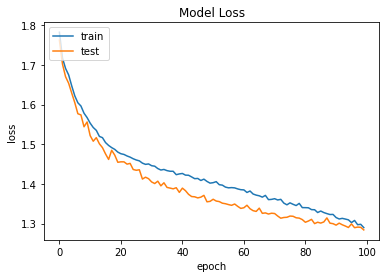

70/70 [==============================] - 2s 29ms/step - loss: 1.3155 - accuracy: 0.4872

Test loss =  1.3155336380004883
Accuracy of the model =  0.487236887216568
F-score of the model =  0.4730762949723278
Confusion Matrix: 
[[258  19   7  58  15   2]
 [ 29 123  28  57  73  76]
 [ 25  36  68  69  69 104]
 [ 55  31  30 176  69  17]
 [  2  26  13  46 224  42]
 [  0  32  19   6  90 239]]


In [ ]:
def train_model_mel():
  #Splitting data 70% training , 30% testing
  x_mel_train, x_mel_test, y_mel_train, y_mel_test = train_test_split(x_mel, y, test_size=0.3, random_state=42)
  
  # Reshaping training data
  x_mel_train = x_mel_train.reshape(-1, 128, 216, 1)
  x_mel_test = x_mel_test.reshape(-1, 128, 216, 1)
  # Normalizing data
  x_mel_train = x_mel_train.astype('float32')
  x_mel_test = x_mel_test.astype('float32')
  #x_mel_train = librosa.util.normalize(x_mel_train)
  #x_mel_test = librosa.util.normalize(x_mel_test)
  x_mel_train = x_mel_train / 255.
  x_mel_test = x_mel_test / 255.

  #print(x_mel_train.shape, x_mel_test.shape,y_mel_train[0],y_mel_test[0])
  #print(x_mel_train.shape, x_mel_test.shape)

  #Splitting training data 5% validation
  x_mel_train, x_mel_valid, y_mel_train, y_mel_valid = train_test_split(x_mel_train, y_mel_train, test_size=0.05, random_state=42)

  #Data Augmentation to reduce overfitting
  #Noise
  print("Before augmentation training x and y size: ",x_mel_train.shape,y_mel_train.shape)
  noise_arr = []
  for i in range(x_mel_train.shape[0]):
    noise_arr.append(noise(x_mel_train[i]))
  noise_arr = np.array(noise_arr)
  x_mel_train = np.append(x_mel_train,noise_arr,axis=0) 
  y_mel_train = np.append(y_mel_train,y_mel_train)
  print("After augmentation training x and y size: ",x_mel_train.shape,y_mel_train.shape)
  
  # Change the labels from categorical to one-hot encoding
  y_mel_train = to_categorical(y_mel_train)
  y_mel_test = to_categorical(y_mel_test)
  y_mel_valid = to_categorical(y_mel_valid)

  #print(x_mel_train.shape, x_mel_test.shape,x_mel_valid.shape,y_mel_valid.shape)
  
  # Building model
  mel_model = Sequential()
  mel_model.add(Conv2D(32, kernel_size=(11, 11),activation='relu',input_shape=(128,216,1),padding='valid'))
  mel_model.add(Conv2D(32, kernel_size=(7, 7),activation='relu',padding='valid'))
  mel_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding='valid'))
  mel_model.add(MaxPooling2D((2, 2),padding='valid'))
  mel_model.add(Dropout(0.25))
  mel_model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='valid'))
  mel_model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='valid'))
  #mel_model.add(BatchNormalization())
  mel_model.add(MaxPooling2D((2, 2),padding='valid'))
  mel_model.add(Dropout(0.25))
  mel_model.add(Conv2D(128, kernel_size=(3, 3),activation='relu',padding='valid'))
  mel_model.add(Conv2D(128, kernel_size=(3, 3),activation='relu',padding='valid'))
  #mel_model.add(BatchNormalization())
  mel_model.add(MaxPooling2D((2, 2),padding='valid'))
  mel_model.add(Dropout(0.25))
  mel_model.add(Conv2D(256, kernel_size=(3, 3),activation='relu',padding='valid'))
  mel_model.add(Conv2D(256, kernel_size=(3, 3),activation='relu',padding='valid'))
  mel_model.add(Conv2D(256, kernel_size=(3, 3),activation='relu',padding='valid'))
  #mel_model.add(BatchNormalization())
  mel_model.add(MaxPooling2D((2, 2),padding='valid'))
  mel_model.add(Dropout(0.25))
  mel_model.add(Flatten())
  mel_model.add(Dense(128, activation='relu'))
  #mel_model.add(BatchNormalization())
  mel_model.add(Dropout(0.25))
  mel_model.add(Dense(6, activation='softmax'))
  # Compiling model using ADAM optimizer
  adam = keras.optimizers.Adam(learning_rate=0.00001)
  mel_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=adam,metrics=['accuracy'])
  # Model summary
  print("\nModel Inspection\n")
  mel_model.summary()
  # Training model
  print("\nModel training\n")
  mel_train_history = mel_model.fit(x_mel_train, y_mel_train, batch_size=128,epochs=100,verbose=2,validation_data=(x_mel_valid, y_mel_valid))

  # Plotting the Train Valid Loss Graph
  plt.plot(mel_train_history.history['loss'])
  plt.plot(mel_train_history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # Calculating accuracy of model
  score = mel_model.evaluate(x_mel_test, y_mel_test)
  print("\nTest loss = ",score[0])
  print("Accuracy of the model = ",score[1])
  predicted_classes = mel_model.predict(x_mel_test)
  predicted_classes = np.argmax(predicted_classes, axis=1)
  y_mel_test = np.argmax(y_mel_test, axis=1)
  print("F-score of the model = ",f1_score(y_mel_test,predicted_classes,average='macro'))
  print("Confusion Matrix: ")
  print(confusion_matrix(y_mel_test,predicted_classes))

  

train_model_mel()

In [ ]:
# Max dimensions of zcr and mel spectrogram
maxn = 0
for i in range(len(x_zcr)):
  if len(x_zcr[i][0]) > maxn:
    maxn = len(x_zcr[i][0])
print("Max dimension=",maxn)

Max dimension= 216
